##Retrieve git repository

In [216]:
! git clone https://github.com/GHGSat/tech-challenge.git

fatal: destination path 'tech-challenge' already exists and is not an empty directory.


## Fix for the following error

```
OpenCV(4.1.2) /io/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'
```



In [217]:
%%shell
VERSION=$(pip show opencv-contrib-python | grep Version)
echo $VERSION
if [ "$VERSION" == "Version: 3.4.2.17" ]; then
  echo "All is good"
else
  pip uninstall opencv-python -y
  # downgrade OpenCV a bit since some none-free features are not avilable
  pip install opencv-contrib-python==3.4.2.17 --force-reinstall
fi

Version: 3.4.2.17
All is good


##Load images

In [218]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [219]:
IMG_IR = "/content/tech-challenge/swdev/datasets/hill-ir-rot-0007.png"
IMG_RGB = "/content/tech-challenge/swdev/datasets/hill-rgb-0007.png"

src = cv.imread(IMG_IR, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(IMG_RGB, cv.IMREAD_GRAYSCALE)

if (src is None) or (img2 is None):
    print('Could not open or find the images: %s %s', IMG_RGB, IMG_IR)
    exit(0)

## ROI

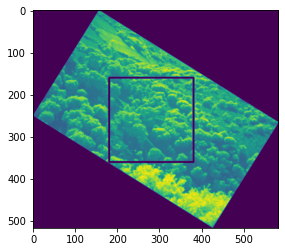

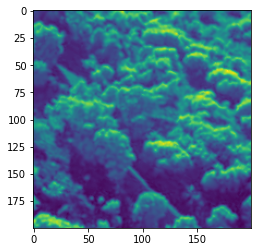

In [220]:
x1, x2, y1, y2 = 180, 380, 160, 360
img1 = src[y1:y2,x1:x2].copy()

cv.line(src, 
        (x1, y1), 
        (x2, y1), 
        (0, 0, 255), 4)
cv.line(src, 
        (x2, y1), 
        (x2, y2), 
        (0, 0, 255), 4)
cv.line(src, 
        (x2, y2), 
        (x1, y2), 
        (0, 0, 255), 4)
cv.line(src, 
        (x1, y2), 
        (x1, y1), 
        (0, 0, 255), 4)

# img1 = src

plt.figure()
plt.imshow(src)
plt.show()

plt.figure()
plt.imshow(img1)
plt.show()

##Feature detection

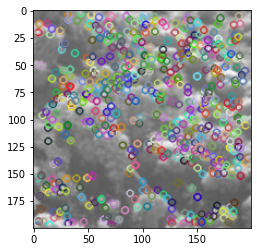

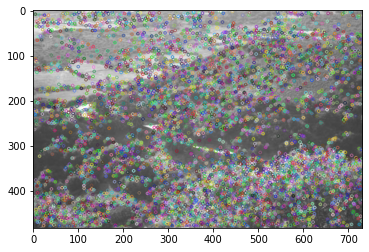

In [221]:
from enum import Enum, auto

class Algorithm(Enum):
  SURF = auto()
  AKAZE = auto()
  SIFT = auto()

# TODO: Determine which algorithm to use (https://ieeexplore.ieee.org/document/8346440)
algo = Algorithm.SIFT

def feature_detection(img):
  if algo == Algorithm.SURF:
    # Detect the keypoints using SURF Detector
    #TODO: How do you determine the minimum Hessian value?
    minHessian = 400 
    detector = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
  elif algo == Algorithm.AKAZE:
    # Detect the keypoints using AKAZE Detector
    detector = cv.AKAZE_create()
  elif algo == Algorithm.SIFT:
    # Detect the keypoints using SIFT Detector
    detector = cv.xfeatures2d_SIFT.create()
  
  keypoints, descriptors = detector.detectAndCompute(img, None)
  return keypoints, descriptors


def display_keypoints(img, keypoints):
  img_keypoints = np.empty((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  cv.drawKeypoints(img, keypoints, img_keypoints) 
  
  plt.figure()
  plt.imshow(img_keypoints)
  plt.show()

keypts1, descriptors1 = feature_detection(img1)
keypts2, descriptors2 = feature_detection(img2)

display_keypoints(img1, keypts1)
display_keypoints(img2, keypts2)



##Feature matching

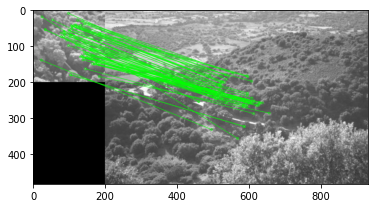

In [222]:

def feature_matching(descriptors1, descriptors2):
  #TODO: Which descriptor use?
  if algo == Algorithm.SURF:
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE)
  elif algo == Algorithm.AKAZE:
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE)
  elif algo == Algorithm.SIFT:
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE)
  
  knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)

  # Filter matches using the Lowe's ratio test
  #TODO: How do you determine the threshold value?
  ratio_thresh = 0.7
  good_matches = []
  for m,n in knn_matches:
      if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

  return good_matches

def display_matches(images, keypoints, matches):
  img_matches = np.empty((max(images[0].shape[0], images[1].shape[0]), images[0].shape[1]+images[1].shape[1], 3), 
                         dtype=np.uint8)
  cv.drawMatches(images[0], keypoints[0], images[1], keypoints[1], matches, img_matches, 
                 matchColor=(0,255,0),
                 flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  plt.figure()
  plt.imshow(img_matches)
  plt.show()
  return img_matches


matches = feature_matching(descriptors1, descriptors2)
img_matches = display_matches((img1, img2), (keypts1, keypts2), matches)

##Homography

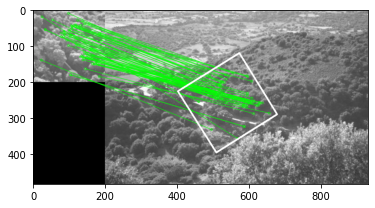

In [223]:
#-- Localize the object
obj = np.empty((len(matches),2), dtype=np.float32)
scene = np.empty((len(matches),2), dtype=np.float32)
for i in range(len(matches)):
    #-- Get the keypoints from the good matches
    obj[i,0] = keypts1[matches[i].queryIdx].pt[0]
    obj[i,1] = keypts1[matches[i].queryIdx].pt[1]
    scene[i,0] = keypts2[matches[i].trainIdx].pt[0]
    scene[i,1] = keypts2[matches[i].trainIdx].pt[1]

H, _ =  cv.findHomography(obj, scene, cv.RANSAC)

#-- Get the corners from the image_1 ( the object to be "detected" )
obj_corners = np.empty((4,1,2), dtype=np.float32)
obj_corners[0,0,0] = 0
obj_corners[0,0,1] = 0
obj_corners[1,0,0] = img1.shape[1]
obj_corners[1,0,1] = 0
obj_corners[2,0,0] = img1.shape[1]
obj_corners[2,0,1] = img1.shape[0]
obj_corners[3,0,0] = 0
obj_corners[3,0,1] = img1.shape[0]

scene_corners = cv.perspectiveTransform(obj_corners, H)

#-- Draw lines between the corners (the mapped object in the scene - image_2 )
cv.line(img_matches, 
        (int(scene_corners[0,0,0] + img1.shape[1]), int(scene_corners[0,0,1])), 
        (int(scene_corners[1,0,0] + img1.shape[1]), int(scene_corners[1,0,1])), 
        (255,255,255), 4)
cv.line(img_matches, 
        (int(scene_corners[1,0,0] + img1.shape[1]), int(scene_corners[1,0,1])),
        (int(scene_corners[2,0,0] + img1.shape[1]), int(scene_corners[2,0,1])), 
        (255,255,255), 4)
cv.line(img_matches, 
        (int(scene_corners[2,0,0] + img1.shape[1]), int(scene_corners[2,0,1])),
        (int(scene_corners[3,0,0] + img1.shape[1]), int(scene_corners[3,0,1])), 
        (255,255,255), 4)
cv.line(img_matches, 
        (int(scene_corners[3,0,0] + img1.shape[1]), int(scene_corners[3,0,1])),
        (int(scene_corners[0,0,0] + img1.shape[1]), int(scene_corners[0,0,1])), 
        (255,255,255), 4)

plt.figure()
plt.imshow(img_matches)
plt.show()


##Alignement

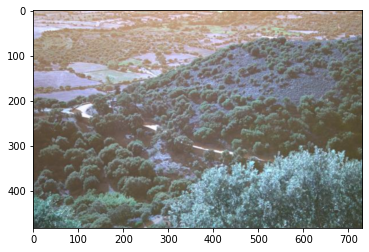

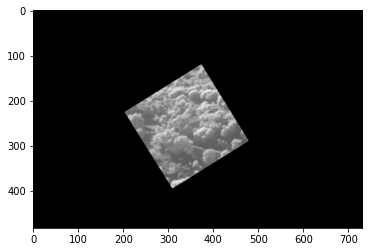

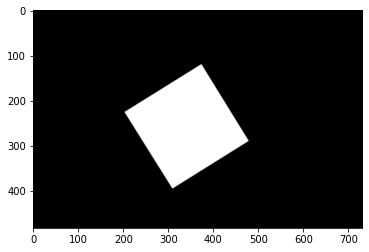

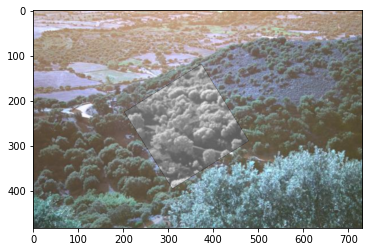

In [269]:
# Re-reading the image
# see: https://docs.opencv.org/master/d4/da8/group__imgcodecs.html
# When using IMREAD_GRAYSCALE, the codec's internal grayscale conversion will be
# used, if available. Results may differ to the output of cvtColor()
src = cv.imread(IMG_IR, cv.IMREAD_UNCHANGED)
img1 = src[y1:y2,x1:x2].copy()
img2 = cv.imread(IMG_RGB, cv.IMREAD_UNCHANGED)

plt.figure()
plt.imshow(img2)
plt.show()

transformed = cv.warpPerspective(src=img1,
                                 dst=np.zeros(img2.shape, img1.dtype), 
                                 M=H, 
                                 dsize=(img2.shape[1], img2.shape[0]),
                                 flags=cv.INTER_LINEAR,
                                 borderMode=cv.BORDER_CONSTANT,
                                 borderValue=(0, 0, 0, 0))

plt.figure()
plt.imshow(transformed)
plt.show()

mask = cv.warpPerspective(src=np.full(img1.shape, (255, 255, 255), np.uint8),
                          dst=np.zeros(img1.shape, np.uint8), 
                          M=H, 
                          dsize=(img2.shape[1], img2.shape[0]),
                          flags=cv.INTER_LINEAR,
                          borderMode=cv.BORDER_CONSTANT,
                          borderValue=0)

plt.figure()
plt.imshow(mask)
plt.show()

np.copyto(img2, transformed, where=mask.astype(np.bool))

plt.figure()
plt.imshow(img2)
plt.show()